<a href="https://colab.research.google.com/github/nedokormysh/GB_intro_NN/blob/lesson6/GB_NN_intro_hw_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
        Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?

In [3]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-24kurbb8
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-24kurbb8
  Created wheel for tensorflow-examples: filename=tensorflow_examples-e2510e7de8354ea89c54ab376ce52371efb39eff_-py3-none-any.whl size=299719 sha256=6ae700b028f1a012409eb87f86a57cd4f739aa834ae2292e73a80f18e0e2dd19
  Stored in directory: /tmp/pip-ephem-wheel-cache-we4wm272/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

import tensorflow as tf

In [5]:
dataset, info = tfds.load('caltech_birds2011', with_info=True)

Dataset caltech_birds2011 downloaded and prepared to ~/tensorflow_datasets/caltech_birds2011/0.1.1. Subsequent calls will reuse this data.


In [6]:
info

tfds.core.DatasetInfo(
    name='caltech_birds2011',
    full_name='caltech_birds2011/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path='~/tensorflow_datasets/caltech_birds2011/0.1.1',
    file_format=tfrecord,
    download_size=1.11 GiB,
    dataset_size=1.11 GiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
      

In [7]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 200
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '

In [8]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  # input_mask -= 1
  return input_image, input_mask

In [9]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [10]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [11]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [12]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [13]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [14]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

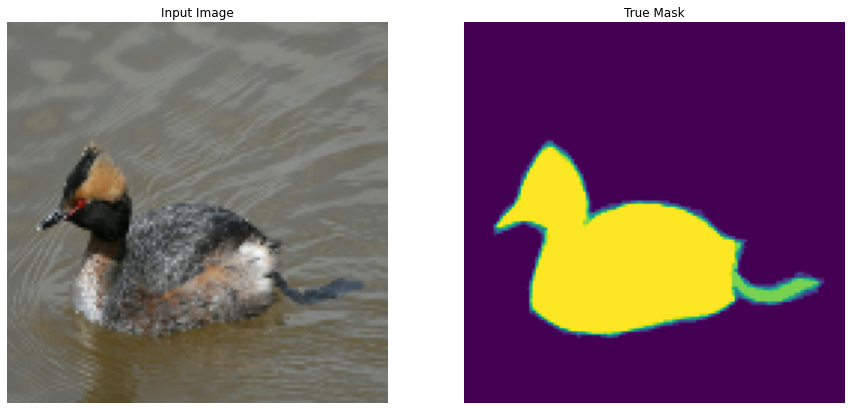

In [15]:
for image, mask in train.take(5):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [16]:
sample_mask.numpy().min(), sample_mask.numpy().max()

(0.0, 255.0)

Будем использовать модифицированный U-Net. В качестве энкодера будет использоваться предтренированный MobileNetV2.
Декодером будет апсемпл блок уже имплементированный в TensorFlow examples [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py).

Причина по который будет испольваться 256 канала заключается в том что у нас 256 возможных лейбла на каждый пиксель. Можно это воспринимать как классификацию где каждый пиксель будет принадлежать одному из 256 классов.

In [17]:
tf.random.set_seed(42)

Как упоминалось ранее энкодером будет предтренированный MobileNetV2, который подготовлен и готов к использованию - [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). Энкодер состоит из определенных аутпутов из средних слоев модели. Обратите внимание энкодр не будет участвовать в процессе тренировкие модели.

In [18]:
OUTPUT_CHANNELS = 256

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step



Декодер/апсемплер это просто серия апсемпл блоков имплементированных в TensorFlow examples.

In [20]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [21]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, 
        strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [22]:
# from tensorflow.keras import backend as K
# # Это наша метрика на Tensorflow

# def dice_coef(y_true, y_pred):
#     return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [23]:
# model = unet_model(OUTPUT_CHANNELS)
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=[dice_coef])

In [24]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Посмотрим на получившуюся архитектуру модели.

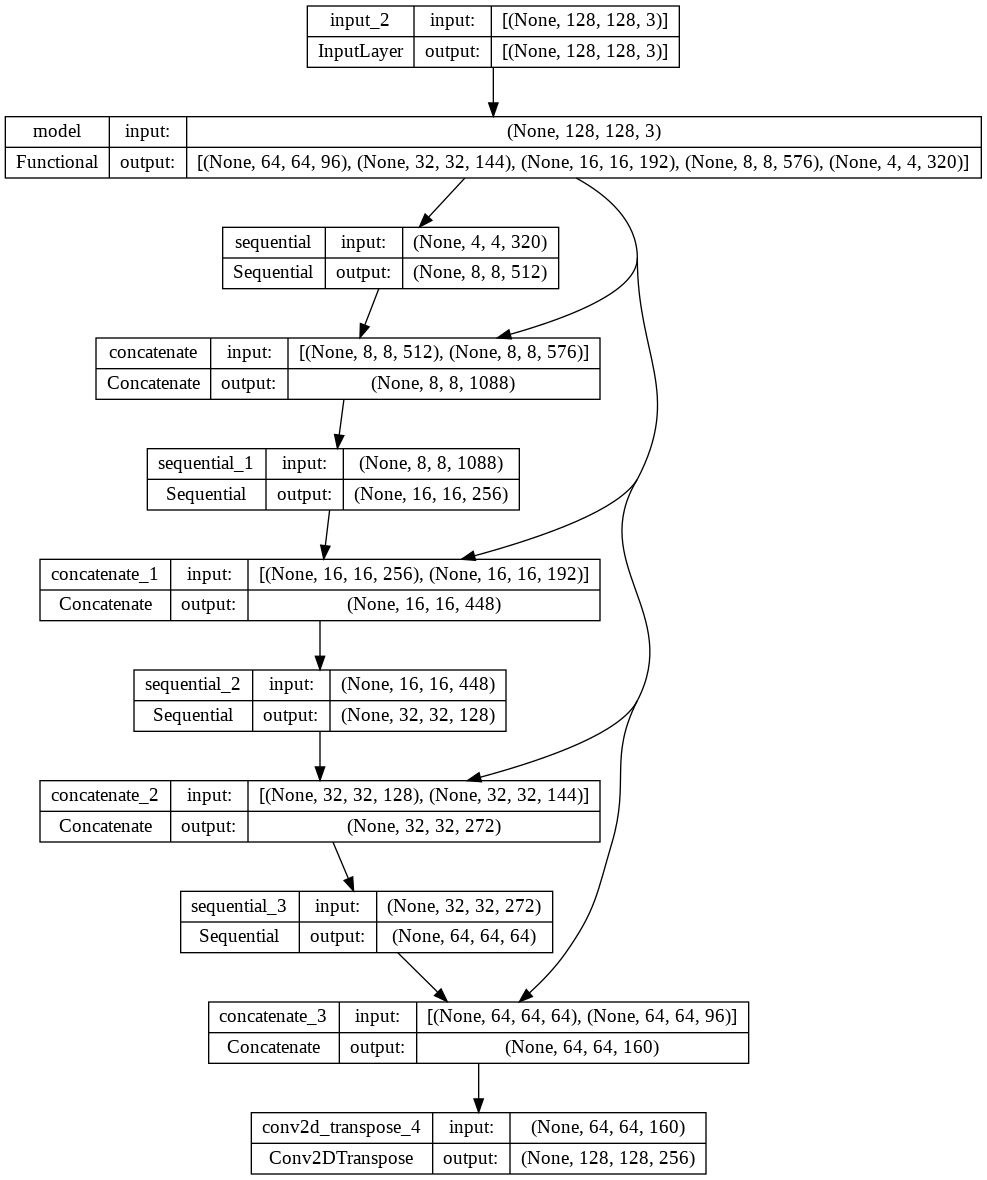

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

Давайте попробуем сделать предсказание с помощью нашей модели до того как началось обучение.

In [26]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [27]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

Рассмотрим, что модель предсказывает перед тренировкой.

1/1 [==============================] - 8s 8s/step


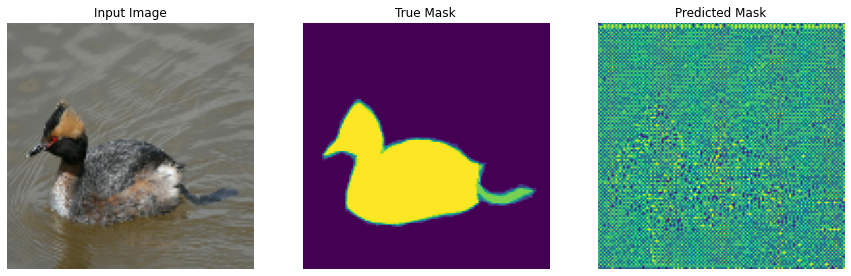

In [28]:
show_predictions()

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

In [31]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 20ms/step


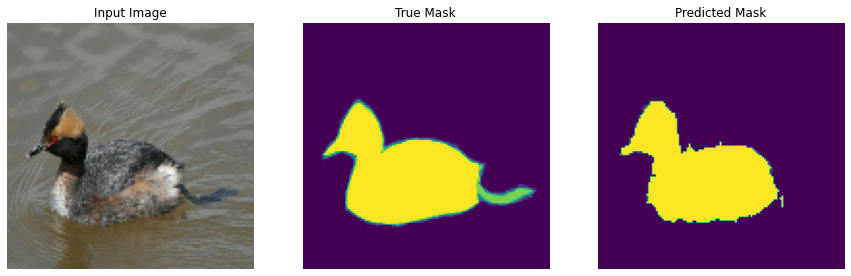


Sample Prediction after epoch 20

93/93 [==============================] - 47s 502ms/step - loss: 0.2765 - accuracy: 0.9436 - val_loss: 0.3973 - val_accuracy: 0.9278


In [32]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // 10 //BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

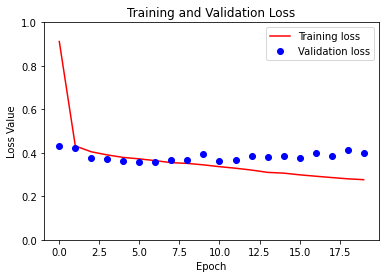

In [33]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 [==============================] - 1s 64ms/step


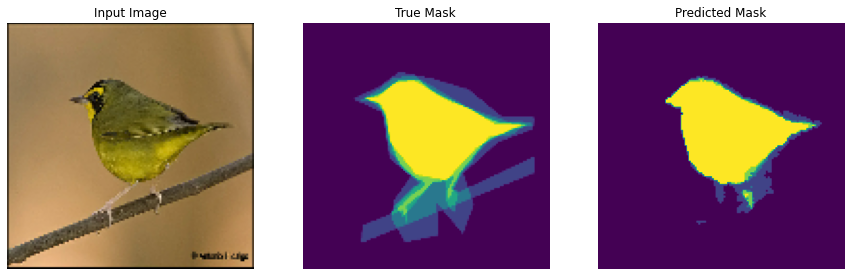

2/2 [==============================] - 0s 144ms/step


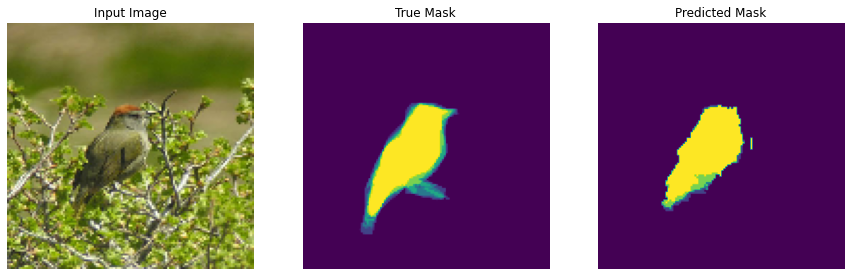

2/2 [==============================] - 0s 127ms/step


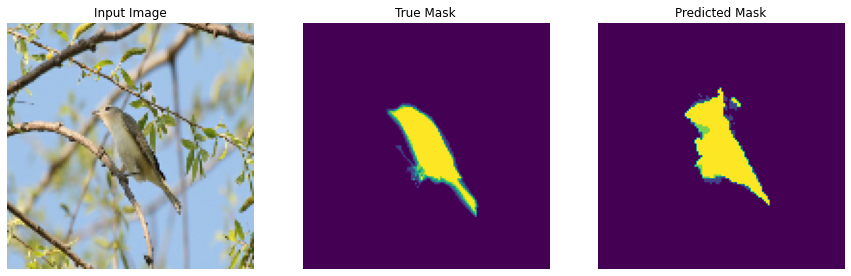

In [34]:
show_predictions(test_dataset, 3)

При увеличении количества эпох training loss падает. Validation loss не изменяется.